# Approximating posterior distributions from neural networks

When we started developing active learning methods, we realised that what we wanted to
achieve required estimating the uncertainty of models. Doing so for neural networks is
an ongoing active research area.

For the purposes of `baal`, we have implemented a few methods that are relatively generic
and work with many neural networks.

All the techniques implemented effectively produce approximate samples from the posterior.
For classification techniques, this means that you usually end up with a 3D tensor rather
than a 2D tensor (`n_batch x n_classes x n_samples` rather than `n_batch x n_classes`).


## Monte-Carlo Dropout

Monte-Carlo Dropout, or MC Dropout, is a very simple way of accessing uncertainty
in a network that include Dropout layers. Essentially, rather than turning off
dropout during inference, you keep in on and make multiple predictions on the
same data. Due to the stochastic zeroing of weights, you'll get a different for
every iteration, even if the input is the same.

This is valid primarily because you trained the network using dropout: You have
already learnt to make predictions without all the weights.

The output is a distribution of predictions.

### Usage

In order to use it, you can simply import Dropout layers from baal and use them in your model construction:


In [1]:
import torch
import baal.bayesian.dropout

standard_model = torch.nn.Sequential(
    torch.nn.Linear(10, 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(8, 4),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4, 2),
)

mc_dropout_model = torch.nn.Sequential(
    torch.nn.Linear(10, 8),
    torch.nn.ReLU(),
    baal.bayesian.dropout.Dropout(p=0.5),
    torch.nn.Linear(8, 4),
    torch.nn.ReLU(),
    baal.bayesian.dropout.Dropout(p=0.5),
    torch.nn.Linear(4, 2),
)

The main difference between these is that the standard model will set the dropout probability to zero during eval, while the MC dropout model will not:

In [2]:
dummy_input = torch.randn(8, 10)

standard_model.eval()
print(bool((standard_model(dummy_input) == standard_model(dummy_input)).all()))

mc_dropout_model.eval()
print(bool((mc_dropout_model(dummy_input) == mc_dropout_model(dummy_input)).all()))


True
False


In order to get a distribution of model outputs, you simply need to repeatedly run the same data through the MC Dropout model. `baal` makes this easier for you by providing a class called `ModelWrapper`. This class accepts your model and a criterion (loss) function, and provides several utility functions, such as running training steps and more. The one that is important for obtaining a posterior distribution is `Modelwrapper.predict_on_batch`.

This method allows you to specify a number of iterations to run the model for, and produces a distribution accordingly:

In [3]:
from baal.modelwrapper import ModelWrapper

wrapped_model = ModelWrapper(
    mc_dropout_model,
    torch.nn.MSELoss()
)

with torch.no_grad():
    predictions = wrapped_model.predict_on_batch(dummy_input, iterations=10000)

The tensor "prediction_distribution" has the shape (batch size) x (output size) x iterations:

In [4]:
predictions.shape

torch.Size([8, 2, 10000])

We can visualise this posterior distribution, for example for the first data point in our
minibatch (although note that because this model is overly simplistic, this is not very
useful):

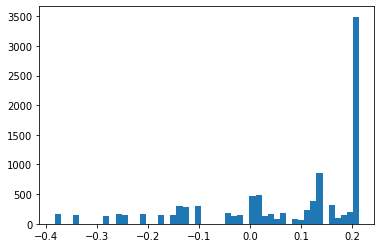

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.hist(predictions[0, 0, :].numpy(), bins=50);
plt.show()

## Drop Connect

DropConnect is another way of accessing uncertainty
in a network. The idea is very similar to MCdropout, however in Dropconnect the weights of a specified layer will directly be dropped without being passed to a Dropout layer. With mulpile pass through the network, similar to MCDropout we will endup with a distribution on the predictions.

Eventually, the benefit of this approach is that you do not need to add a Dropout layer to a netwrok which doesn't have one. In long term using DropConnect is going to surpass MCDropout results in active learning but the draw backs is the essential need of almost twice iterations and longer trainings for the model to converge at each active learning step.

### Usage
As usual we have pre-implemented wrappers to ease your job for this. Example below shows how to use this module:

In [6]:
import torch
class DummyModel(torch.nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.conv = torch.nn.Conv2d(3, 8, kernel_size=10)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(8, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [7]:
import numpy as np
from baal.bayesian import MCDropoutConnectModule
from baal.modelwrapper import ModelWrapper

dummy_model = DummyModel()
dummy_input = torch.from_numpy(np.ones([3, 10, 10]) * 1 / 255.).float()
model = MCDropoutConnectModule(dummy_model, layers=['Linear'], weight_dropout=0.9)
wrapped_model = ModelWrapper(model, torch.nn.CrossEntropyLoss(), replicate_in_memory=False)
with torch.no_grad():
    predictions = wrapped_model.predict_on_batch(dummy_input.unsqueeze(0), iterations=10000)

In [8]:
predictions.shape

torch.Size([1, 1, 10000])

let's visualize the posterior:

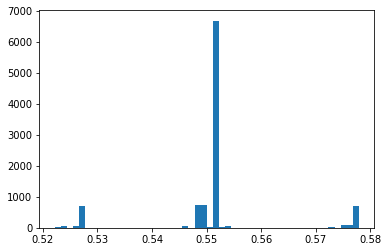

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.hist(predictions[0, 0, :].numpy(), bins=50);
plt.show()